In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn, spherical_yn
from scipy.optimize import root_scalar

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif"
})

### Definition of spherical harmonics

In [2]:
j1 = lambda z: spherical_jn(1,z)
j2 = lambda z: spherical_jn(2,z)
y1 = lambda z: spherical_yn(1,z)
y2 = lambda z: spherical_yn(2,z)

### Some constants

In [3]:
G = 6.67e-11

# Dimensions
R_jupiter = 69.9e6
m_neptune = 1.024e26
R_neptune = 24.6e6
rho_neptune = m_neptune/(4*np.pi/3*R_neptune**3)
m_jupiter = 1.898e27

# Material properties
rho_air = 1.293
rigidity_air = 1e-7
viscosity_air = 3e-5
rigidity_earth = 1e11
viscosity_earth = 1e21

### Setting simulation parameters

In [4]:
R_core = np.linspace(0.1*R_jupiter,0.6*R_jupiter)
R = R_jupiter
Mp = m_jupiter
mu = 900*1e3*1e5 #shear modulus, 
rho_core0 = 6000

### Storch & Lai Figure 1

In [5]:
def rho_core_func(K, R_core, rho_core0):
    q = np.sqrt(2*np.pi*G*R**2/K) #eq. 5
    rho0 = q**2*Mp/(4*np.pi*R**3) # eq. 6
    rho_max = rho0*np.sin(q*(1-R_core/R))/(q*R_core/R) # eq. 7
    rho_core = rho_max*3*R**2/(q**2*R_core**2)*(q*R_core/R*1/np.tan(q*(1-R_core/R))+1)
    return rho_core-rho_core0

K = np.zeros(len(R_core))
for i in range(len(R_core)):
    #print(i)
    #print(np.sqrt(2*np.pi*G*R**2/(1e7)))
    sol = root_scalar(lambda x: rho_core_func(x, R_core[i], rho_core0), bracket=[2*G*R**2/np.pi, 1e7])
    K[i] = sol.root

In [6]:
q = np.sqrt(2*np.pi*G*R**2/K) #eq. 5
rho0 = q**2*Mp/(4*np.pi*R**3) # eq. 6
rho_max = rho0*np.sin(q*(1-R_core/R))/(q*R_core/R) # eq. 7
rho_core = rho_max*3*R**2/(q**2*R_core**2)*(q*R_core/R*1/np.tan(q*(1-R_core/R))+1)
g_core = 4*np.pi/3*G*rho_core*R_core

mu_bar = 19*mu/(2*rho_core*g_core*R_core)
chi_core = q*R_core/R

alpha = j1(q)*(chi_core*y1(chi_core)-5*y2(chi_core)) - y1(q)*(chi_core*j1(chi_core)-5*j2(chi_core))
lambdaa = y1(q)*j2(chi_core) - j1(q)*y2(chi_core)
gamma = j2(q)*(chi_core*y1(chi_core) - 5*y2(chi_core)) - y2(q)*(chi_core*j1(chi_core)-5*j2(chi_core))

h2c = 5/q**2*(R/R_core)**3*(alpha*(1+2*mu_bar/(5*(1-rho_max/rho_core)))-3*lambdaa*(1-rho_max/rho_core))**(-1)
k2 = 3*h2c/(q*alpha)*(R_core/R)**2*(1-rho_max/rho_core)+5*gamma/(q*alpha)-1 # eq. 24

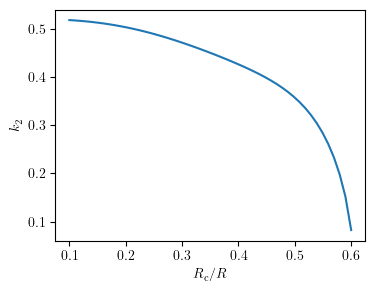

In [7]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(R_core/R, k2)
ax.set_xlabel("$R_\\mathrm{c}/R$")
ax.set_ylabel("$k_2$")
plt.show()


### Constant core radius, varying atmosphere
The atmosphere used in Storch & Lai is a polytrope in HE, so it is not of homogeneous density. Here we set $\rho_0$ such that the mass of the atmosphere is equal to the mass of a homogeneous atmosphere with density $\rho_\mathrm{atm}$

In [8]:
def find_K(K, R_core, R, rho_atm, rho_core):
    M_atm = 4*np.pi/3*(R**3-R_core**3)*rho_atm # Target atmosphere density
    Mp = 4*np.pi/3*R_core**3*rho_core + M_atm

    q = np.sqrt(2*np.pi*G*R**2/K)
    rho0 = q**2*Mp/(4*np.pi*R**3)
    r = np.linspace(R_core, R, 100)
    dr = r[1]-r[0]
    rho = rho0*np.sin(q*(1-r/R)/(q*r/R))
    M = np.sum(4*np.pi*r**2*rho*dr)
    return M-M_atm


R_core = R_neptune
rho_core = rho_neptune
rho_atm = rho_air
R_array = np.logspace(np.log10(R_neptune), np.log10(10*R_jupiter), 100)
K_array = np.zeros(len(R_array))

for i in range(len(R_array)):
    sol = root_scalar(find_K, args=(R_core, R_array[i], rho_atm, rho_core), x0=1e7)
    K_array[i] = sol.root


/home/nielssw/astrovaria/astrovaria_env/lib/python3.12/site-packages/scipy/optimize/_root_scalar.py:327: RuntimeWarning: Derivative was zero.
  r, sol = methodc(f, x0, args=args, fprime=fprime, fprime2=None,
/tmp/ipykernel_19469/3404530821.py:5: RuntimeWarning: invalid value encountered in sqrt
  q = np.sqrt(2*np.pi*G*R**2/K)


In [36]:
def get_k2(K, R, R_core, rho_core, rho_atm, mu):
    Mp = 4*np.pi/3*R_core**3*rho_core + 4*np.pi/3*(R**3-R_core**3)*rho_atm

    q = np.sqrt(2*np.pi*G*R**2/K) #eq. 5
    rho0 = q**2*Mp/(4*np.pi*R**3) # eq. 6
    rho_max = rho0*np.sin(q*(1-R_core/R))/(q*R_core/R) # eq. 7
    rho_core2 = rho_max*3*R**2/(q**2*R_core**2)*(q*R_core/R*1/np.tan(q*(1-R_core/R))+1)#! WHY DOES THIS CALCULATE RHO CORE??? THIS SHOULD BE A GIVEN CONSTANT
    g_core = 4*np.pi/3*G*rho_core*R_core

    mu_bar = 19*mu/(2*rho_core*g_core*R_core)
    chi_core = q*R_core/R

    alpha = j1(q)*(chi_core*y1(chi_core)-5*y2(chi_core)) - y1(q)*(chi_core*j1(chi_core)-5*j2(chi_core))
    lambdaa = y1(q)*j2(chi_core) - j1(q)*y2(chi_core)
    gamma = j2(q)*(chi_core*y1(chi_core) - 5*y2(chi_core)) - y2(q)*(chi_core*j1(chi_core)-5*j2(chi_core))

    h2c = 5/q**2*(R/R_core)**3*(alpha*(1+2*mu_bar/(5*(1-rho_max/rho_core)))-3*lambdaa*(1-rho_max/rho_core))**(-1)
    k2 = 3*h2c/(q*alpha)*(R_core/R)**2*(1-rho_max/rho_core)+5*gamma/(q*alpha)-1 # eq. 24

    return k2

In [37]:
k2_array = get_k2(K_array, R_array, R_core, rho_core, rho_atm, rigidity_earth)

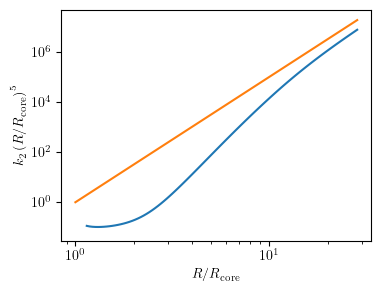

In [38]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(R_array/R_core, k2_array*(R_array/R_core)**5)
ax.plot(R_array/R_core, (R_array/R_core)**5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$R/R_\\mathrm{core}$")
ax.set_ylabel("$k_2\\left(R/R_\\mathrm{core}\\right)^5$")
plt.show()

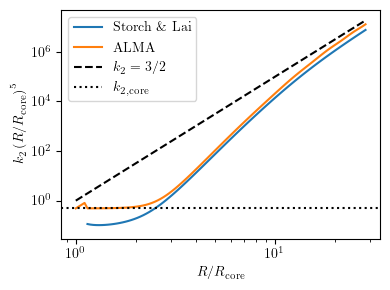

In [39]:
ALMA_data = np.load("polytrope_data.npz")
k2_array_ALMA = ALMA_data["k2_array"]
R_array_ALMA = ALMA_data["R_array"]

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(R_array/R_core, k2_array*(R_array/R_core)**5, label="Storch \\& Lai")
ax.plot(R_array_ALMA/R_core, k2_array_ALMA*(R_array_ALMA/R_core)**5, label="ALMA")
ax.plot(R_array/R_core, (R_array/R_core)**5, color="black", linestyle="--", label="$k_2=3/2$")
ax.axhline(3/(2*(1+19*rigidity_earth/(2*rho_core*R_core*4*np.pi*G/3*rho_core*R_core))), color="black", linestyle=":", label="$k_{2,\\mathrm{core}}$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$R/R_\\mathrm{core}$")
ax.set_ylabel("$k_2\\left(R/R_\\mathrm{core}\\right)^5$")
ax.legend()
fig.tight_layout()
plt.show()